In [ ]:
!unzip glove.6B.zip -d my_data


unzip:  cannot find or open glove.6B.zip, glove.6B.zip.zip or glove.6B.zip.ZIP.


In [2]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


In [156]:
import tensorflow as tf
import keras
from keras.layers import Dense, Embedding, Input, Flatten, LSTM, Conv1D, concatenate, MaxPooling1D
from keras.models import Sequential, Model
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB


In [158]:
max_len = 50
embedding_dim = 100

In [159]:
sns.set_theme(style="whitegrid")
df = pd.read_csv("train.csv").sample(frac=1, random_state=42)
test = pd.read_csv("test.csv")

In [160]:
# val = pd.DataFrame()
# for label_value in df['label'].unique():
#     label_subset = df[df['label'] == label_value].head(1000)
#     val = pd.concat([val, label_subset])


In [161]:
val = df.sample(n=20000, random_state=43)
val, len(val)

(            id    tid1    tid2  \
 40570    63189   27789   27799   
 225266  155616  148058   51188   
 17687   206693   11759  118785   
 13783      514    9069    9086   
 127289   43785   84803   84824   
 ...        ...     ...     ...   
 113467  216908   75729   75740   
 238386   12819  156316   49706   
 82300   254392   55573  113891   
 247598  211362  161505   24582   
 124551   77680   82910   51018   
 
                                                 title1_en  \
 40570   Legend has it that a "negative-calorie diet" c...   
 225266  Your teeth are smelly and yellow, and don't co...   
 17687                            Zhang Han's new romance?   
 13783   The beginning of 2018, rural homestead new tre...   
 127289  It turns out that Huojian's mother's attitude ...   
 ...                                                   ...   
 113467  It's gone! It's rare and it's made of jade. It...   
 238386  Instant fury ran into the ring, and Yang Jian-...   
 82300   Remind! Two

In [162]:
val['label'].value_counts()

unrelated    13686
agreed        5770
disagreed      544
Name: label, dtype: int64

In [163]:
val.head()

,id,tid1,tid2,title1_en,title2_en,label
40570,63189,27789,27799,"Legend has it that a ""negative-calorie diet"" c...","Is it that ""negative calorie food"" that you ea...",agreed
225266,155616,148058,51188,"Your teeth are smelly and yellow, and don't co...",Do you believe the six rumors of tooth cleaning?,unrelated
17687,206693,11759,118785,Zhang Han's new romance?,"Once again, Zhang Han is in love with her, thi...",unrelated
13783,514,9069,9086,"The beginning of 2018, rural homestead new tre...",The rural people over 55 years of age with dis...,unrelated
127289,43785,84803,84824,It turns out that Huojian's mother's attitude ...,Huo Jianghua's mother's attitude towards Lin X...,agreed


In [164]:
df.drop(columns=['id', 'tid1', 'tid2'], inplace=True)

In [165]:
df.head()

,title1_en,title2_en,label
104355,Homemade rat poison. One dead litter.,"Homemade rat poison, one dead, one dead, all k...",agreed
133170,"By eating these five kinds of vegetables, you ...","Zhang DaDa ""day"" upside down begging for growt...",unrelated
221087,The Shenzhen Nailed Nailed Households Resume $...,Chengdu homebuyers can't buy a house with half...,unrelated
135365,"Wu Jing may face a compensation of 1 billion, ...","With billions of dollars in compensation, Wuji...",agreed
170183,"Yin Xiangjie out of prison, invited Mandar to ...",is xu qing 's current husband a gao bo? the fa...,unrelated


In [166]:
train = df[~df.isin(val)].dropna()

In [167]:
train.head()

,title1_en,title2_en,label
104355,Homemade rat poison. One dead litter.,"Homemade rat poison, one dead, one dead, all k...",agreed
133170,"By eating these five kinds of vegetables, you ...","Zhang DaDa ""day"" upside down begging for growt...",unrelated
221087,The Shenzhen Nailed Nailed Households Resume $...,Chengdu homebuyers can't buy a house with half...,unrelated
135365,"Wu Jing may face a compensation of 1 billion, ...","With billions of dollars in compensation, Wuji...",agreed
170183,"Yin Xiangjie out of prison, invited Mandar to ...",is xu qing 's current husband a gao bo? the fa...,unrelated


In [168]:
train.label.value_counts(), df.label.value_counts()

(unrelated    161912
 agreed        68468
 disagreed      6062
 Name: label, dtype: int64,
 unrelated    175598
 agreed        74238
 disagreed      6606
 Name: label, dtype: int64)

In [169]:
len(train)

236442

In [170]:
df.head()

,title1_en,title2_en,label
104355,Homemade rat poison. One dead litter.,"Homemade rat poison, one dead, one dead, all k...",agreed
133170,"By eating these five kinds of vegetables, you ...","Zhang DaDa ""day"" upside down begging for growt...",unrelated
221087,The Shenzhen Nailed Nailed Households Resume $...,Chengdu homebuyers can't buy a house with half...,unrelated
135365,"Wu Jing may face a compensation of 1 billion, ...","With billions of dollars in compensation, Wuji...",agreed
170183,"Yin Xiangjie out of prison, invited Mandar to ...",is xu qing 's current husband a gao bo? the fa...,unrelated


In [171]:
test.head()

,id,tid1,tid2,title1_en,title2_en
0,256442,100672,100673,"The great coat brother Zhu Zhu Wen, in the man...","Lin xinsheng after the birth of ""hard milking,..."
1,256443,162269,162270,NASA reveals facts about UFO wreckage found on...,"The UFO found in Yuancun, Jiaocheng County, Sh..."
2,256444,157826,157854,The hollow tomatoes are loaded with hormones.,"Li chenfan bingbing home photos, netizen: this..."
3,256445,109579,74076,Ange Pavilion Geoshui: How accurate is Matrimo...,Master one: the eight-character presumption of...
4,256446,15068,15085,A 50-year-old bus-bus blows up an 8-year-old c...,< i > Joe Johnson's disgruntled timing and ord...


In [172]:
df.isnull().sum(), test.isnull().sum()

(title1_en    0
 title2_en    0
 label        0
 dtype: int64,
 id           0
 tid1         0
 tid2         0
 title1_en    0
 title2_en    0
 dtype: int64)

#### There are no missing values

In [173]:
df['label'].unique()

array(['agreed', 'unrelated', 'disagreed'], dtype=object)

Text(0.5, 0, 'Labels')

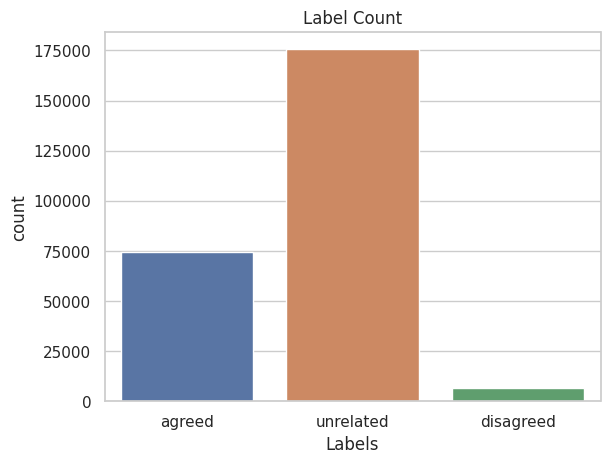

In [174]:
sns.countplot(x=df['label'])
plt.title("Label Count")
plt.xlabel("Labels")

Text(0.5, 0, 'Labels')

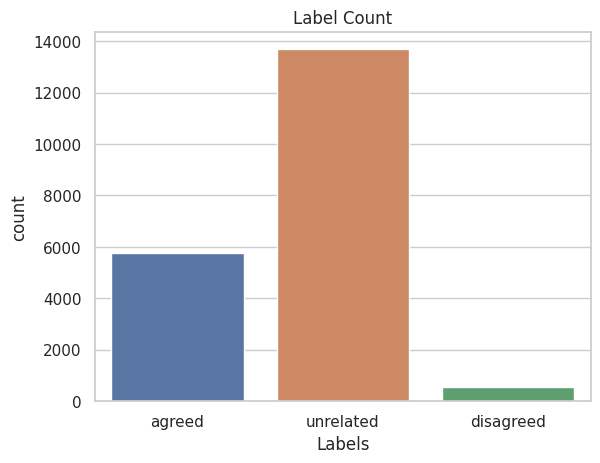

In [175]:
sns.countplot(x=val['label'])
plt.title("Label Count")
plt.xlabel("Labels")

In [176]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [177]:
import nlpaug.augmenter.word as naw
syn_aug = naw.SynonymAug(aug_p=0.3, aug_max=1)

In [178]:
disagreed_train = train[train.label=='disagreed']
curr = []
for i, s in enumerate(disagreed_train.iloc[:, 0]):
    l = []
    mod_sentence = syn_aug.augment(s, n=1)[0]
    if mod_sentence != disagreed_train.iloc[i, 0]:
        l.append(mod_sentence)
        l.append(disagreed_train.iloc[i, 1])
        l.append(disagreed_train.iloc[i, 2])
        curr.append(l)

for i, s in enumerate(disagreed_train.iloc[:, 0]):
    l = []
    mod_sentence1 = syn_aug.augment(s, n=1)[0]
    mod_sentence2 = syn_aug.augment(disagreed_train.iloc[i, 1], n=1)[0]
    if mod_sentence1 != disagreed_train.iloc[i, 0] and mod_sentence2 != disagreed_train.iloc[i, 1]:
        l.append(mod_sentence1)
        l.append(mod_sentence2)
        l.append(disagreed_train.iloc[i, 2])
        curr.append(l)

for i, s in enumerate(disagreed_train.iloc[:, 1]):
    l = []
    mod_sentence = syn_aug.augment(s, n=1)[0]
    if mod_sentence != disagreed_train.iloc[i, 1]:
        l.append(disagreed_train.iloc[i, 0])
        l.append(mod_sentence)
        l.append(disagreed_train.iloc[i, 2])
        curr.append(l)


In [179]:
len(curr), len(disagreed_train)

(14803, 6062)

In [180]:
syn_aug = naw.SynonymAug(aug_p=0.3, aug_max=3)

In [181]:
for i, s in enumerate(disagreed_train.iloc[:, 0]):
    l = []
    mod_sentence = syn_aug.augment(s, n=1)[0]
    if mod_sentence != disagreed_train.iloc[i, 0]:
        l.append(mod_sentence)
        l.append(disagreed_train.iloc[i, 1])
        l.append(disagreed_train.iloc[i, 2])
        curr.append(l)

for i, s in enumerate(disagreed_train.iloc[:, 0]):
    l = []
    mod_sentence1 = syn_aug.augment(s, n=1)[0]
    mod_sentence2 = syn_aug.augment(disagreed_train.iloc[i, 1], n=1)[0]
    if mod_sentence1 != disagreed_train.iloc[i, 0] and mod_sentence2 != disagreed_train.iloc[i, 1]:
        l.append(mod_sentence1)
        l.append(mod_sentence2)
        l.append(disagreed_train.iloc[i, 2])
        curr.append(l)

for i, s in enumerate(disagreed_train.iloc[:, 1]):
    l = []
    mod_sentence = syn_aug.augment(s, n=1)[0]
    if mod_sentence != disagreed_train.iloc[i, 1]:
        l.append(disagreed_train.iloc[i, 0])
        l.append(mod_sentence)
        l.append(disagreed_train.iloc[i, 2])
        curr.append(l)

In [182]:
len(curr)

32620

In [183]:
curr = np.array(curr)

In [184]:
AGREED_COUNT = train['label'].value_counts()[1]
unrelated_train = train[train.label=='unrelated']
agreed_train = train[train.label=='agreed']
disagreed_train = train[train.label=='disagreed']
additional_data = pd.DataFrame(data=curr, columns=['title1_en', 'title2_en', 'label'])
train = pd.concat([unrelated_train, agreed_train, disagreed_train, additional_data], axis=0)

In [185]:
train = train.sample(frac=1, random_state=42)

In [186]:
train.columns

Index(['title1_en', 'title2_en', 'label'], dtype='object')

Text(0.5, 0, 'Labels')

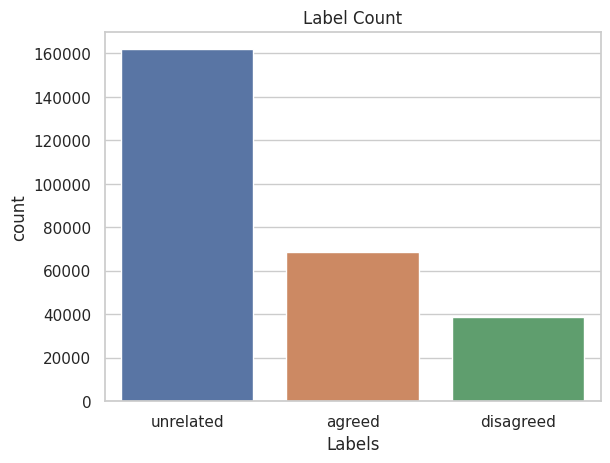

In [187]:
sns.countplot(x=train['label'])
plt.title("Label Count")
plt.xlabel("Labels")

In [188]:
train['label'] = train['label'].map({'unrelated':0, 'agreed':1, 'disagreed':2}).astype(np.uint8)
train.label.unique()

array([0, 1, 2], dtype=uint8)

In [189]:
train['label'].value_counts()

0    161912
1     68468
2     38682
Name: label, dtype: int64

In [190]:
val['label'] = val['label'].map({'unrelated':0, 'agreed':1, 'disagreed':2}).astype(np.uint8)

In [191]:
train.head()

,title1_en,title2_en,label
162755,Xiaogan experimental school section a drive-by...,Police in nanjing: eight netizens have been ar...,0
116998,Ma just unveiled five low-cost Internet start-...,"Chery dismisses rumors: there is no ""whole pac...",0
110568,Lumbar disc protruding a pig's foot easy to ha...,"Dizzy hand, pig's feet so eat many benefits, t...",1
163708,"Li Xiaolu's night-sleepover event, the TV dram...","Li Xiaolu because of the affair, the cause all...",1
47100,Don't believe these five children's rumors abo...,"Qiaojia 2 children are killed, the murderer ha...",0


In [192]:
train['label'].value_counts()

0    161912
1     68468
2     38682
Name: label, dtype: int64

### Text preprocessing
#### Assign an index to each word
#### Count words to see most common words

In [193]:
#  keras.datasets.imdb.load_data(num_words=max_words)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

UNWANTED_WORDS = ['ho', 'unk', 'ha', 'honey']
def transform_text(s):
    # Remove websites
    s = re.sub(r"http\S+", "", s) 
    s = re.sub(r"www.\S+", "", s) 
    # Remove numbers
    s = re.sub(r'\d+', '', s)
    # Remove punctuation
    s = "".join([char.lower() for char in s if char not in string.punctuation])
    tokenized = word_tokenize(s)
    tokenized =  [w for w in tokenized if not w.lower() in stop_words]
    # Apply lemmatization
    tokenized = [lemmatizer.lemmatize(w) for w in tokenized]

    return tokenized

curr = 1
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
str_to_int = dict()
word_count = dict()
title1_en = []
title2_en = []
# Preprocess training
for s in train['title1_en']:
  tokenized = transform_text(s)
  l = []
  for w in tokenized:
    if w in UNWANTED_WORDS:
      l.append(0)
      continue
    if w not in str_to_int:
      str_to_int[w] = curr
      word_count[w] = 1
      curr += 1
    if w in word_count: word_count[w] += 1
    l.append(str_to_int[w])
  # if len(l) < max_len:
  title1_en.append(l)

for s in train['title2_en']:
  tokenized = transform_text(s)
  l = []
  for w in tokenized:
    if w in UNWANTED_WORDS:
      l.append(0)
      continue
    if w not in str_to_int:
      str_to_int[w] = curr
      word_count[w] = 1
      curr += 1
    if w in word_count: word_count[w] += 1
    l.append(str_to_int[w])
  # if len(l) < max_len:
  title2_en.append(l)

# Preprocess validation
# Preprocess testing
val_title1_en = []
val_title2_en = []
for s in val['title1_en']:
  tokenized = transform_text(s)
  l = []
  for w in tokenized:
    if w in UNWANTED_WORDS:
      l.append(0)
      continue
    if w not in str_to_int:
      print("not in")
      str_to_int[w] = 0

    if w in word_count: word_count[w] += 1
    l.append(str_to_int[w])
  # if len(l) < max_len:
  val_title1_en.append(l)

for s in val['title2_en']:
  tokenized = transform_text(s)
  l = []
  for w in tokenized:
    if w in UNWANTED_WORDS:
      l.append(0)
      continue
    if w not in str_to_int:
      str_to_int[w] = 0
    if w in word_count: word_count[w] += 1
    l.append(str_to_int[w])
  val_title2_en.append(l)
    
# Preprocess testing
test_title1_en = []
test_title2_en = []
for s in test['title1_en']:
  tokenized = transform_text(s)
  l = []
  for w in tokenized:
    if w in UNWANTED_WORDS:
      l.append(0)
      continue
    if w not in str_to_int:
      print("not in")
      str_to_int[w] = 0

    if w in word_count: word_count[w] += 1
    l.append(str_to_int[w])
  # if len(l) < max_len:
  test_title1_en.append(l)

for s in test['title2_en']:
  tokenized = transform_text(s)
  l = []
  for w in tokenized:
    if w in UNWANTED_WORDS:
      l.append(0)
      continue
    if w not in str_to_int:
      str_to_int[w] = 0
    if w in word_count: word_count[w] += 1
    l.append(str_to_int[w])
  test_title2_en.append(l)

    
  
    

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in

In [194]:
max_words = len(list(str_to_int.values()))
max_words

46928

In [195]:
max_len = 0
for d in test_title1_en:
   if len(d) > max_len:
     max_len = len(d) 
     print(d)
     print(len(d))
    

for d in test_title2_en:
    if len(d) > max_len:
     max_len = len(d) 
     print(d)
     print(len(d))

for d in val_title1_en:
    if len(d) > max_len:
     max_len = len(d) 
     print(d)
     print(len(d))

for d in val_title2_en:
    if len(d) > max_len:
     max_len = len(d) 
     print(d)
     print(len(d))

for d in title1_en:
    if len(d) > max_len:
     max_len = len(d) 
     print(d)
     print(len(d))

for d in title2_en:
    if len(d) > max_len:
     max_len = len(d) 
     print(d)
     print(len(d))

print()

def find_key(input_dict, value):
  return next((k for k, v in input_dict.items() if v == value), None)

find_key(str_to_int, 2225), find_key(str_to_int, 258), find_key(str_to_int, 7682)


[374, 13772, 1297, 1815, 1815, 1988, 5136, 97, 794, 1439, 794, 113, 42432, 5367, 153]
15
[1497, 1498, 5206, 2190, 19805, 1329, 6079, 22099, 405, 15611, 3241, 2238, 69, 5368, 22100, 1163, 405, 69, 405, 549]
20
[475, 320, 2381, 960, 526, 1864, 4252, 5882, 1677, 503, 0, 1483, 3797, 3691, 3286, 284, 884, 3411, 138, 1649, 65, 187, 7501, 3877, 352]
25
[3642, 5993, 4326, 2601, 8986, 2601, 951, 650, 5870, 3471, 3943, 5831, 1387, 270, 3493, 156, 952, 131, 274, 3471, 952, 3493, 2333, 960, 3027, 4503]
26
[2285, 3760, 3761, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355, 507, 1355]
41
[20527, 439, 1270, 3619, 245, 7115, 7324, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

('resist', 'spanking', 'fiske')

In [196]:
# train = train[['title1_en', 'title2_en']]
# Padding training set
title1_en_padded = pad_sequences(np.array(title1_en), maxlen=max_len)
title2_en_padded = pad_sequences(np.array(title2_en), maxlen=max_len)
# Padding validation set
val_title1_en_padded = pad_sequences(np.array(val_title1_en), maxlen=max_len)
val_title2_en_padded = pad_sequences(np.array(val_title2_en), maxlen=max_len)
# Padding testing set
test_title1_en_padded = pad_sequences(np.array(test_title1_en), maxlen=max_len)
test_title2_en_padded = pad_sequences(np.array(test_title2_en), maxlen=max_len)
train_full = np.array([np.array([title1_en_padded[i], title2_en_padded[i]]) for i in range(len(title1_en_padded))])
len(train['label']), len(title1_en), len(title2_en)


# X_train, X_val, y_train, y_val = train_test_split(train_full, train['label'], test_size=0, random_state=42)

<ipython-input-196-72d927538e67>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  title1_en_padded = pad_sequences(np.array(title1_en), maxlen=max_len)
<ipython-input-196-72d927538e67>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  title2_en_padded = pad_sequences(np.array(title2_en), maxlen=max_len)
<ipython-input-196-72d927538e67>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

(269062, 269062, 269062)

#### Our model is intended to have 2 inputs

In [197]:
input1 = train_full[:, 0, :]
input2 = train_full[:, 1, :]
val1 = val_title1_en_padded
val2 = val_title2_en_padded
test1 = test_title1_en_padded
test2 = test_title2_en_padded

In [198]:
print(input1[-1][-1], input2[-1][-1])

1152 1899


In [199]:
# Model
inputs1 = Input(shape=(None,), name='title1_en') # title1_en
inputs2 = Input(shape=(None,), name='title2_en') # title2_en

embedding1 = Embedding(max_words, embedding_dim-50)(inputs1)
embedding2 = Embedding(max_words, embedding_dim-50)(inputs2)

conv1 = Conv1D(128, 3, activation='relu')(embedding1)
conv2 = Conv1D(128, 3, activation='relu')(embedding2)

pool1 = MaxPooling1D()(conv1)
pool2 = MaxPooling1D()(conv2)

lstm1 = LSTM(64)(pool1)
lstm2 = LSTM(64)(pool2)

x1 = Dense(32)(lstm1)
x2 = Dense(32)(lstm2)

conc = concatenate([x1, x2], axis=-1)
x = Dense(16, activation='relu')(conc)

y = Dense(3, activation='softmax')(x)

model = Model([inputs1, inputs2], y)
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title1_en (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 title2_en (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 50)     2346400     ['title1_en[0][0]']              
                                                                                                  
 embedding_5 (Embedding)        (None, None, 50)     2346400     ['title2_en[0][0]']              
                                                                                            

In [200]:
train['label']

162755    0
116998    0
110568    1
163708    1
47100     0
         ..
215683    0
22736     2
199192    0
65197     0
158478    0
Name: label, Length: 269062, dtype: uint8

In [201]:
val['label'], len(val2)

(40570     1
 225266    0
 17687     0
 13783     0
 127289    1
          ..
 113467    0
 238386    1
 82300     0
 247598    0
 124551    0
 Name: label, Length: 20000, dtype: uint8,
 20000)

In [202]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy']) 
history = model.fit([input1, input2], np.array(train['label']), validation_data=([val1, val2], val['label']), epochs=5)

Epoch 1/5
8409/8409 [==============================] - 210s 24ms/step - loss: 0.5746 - accuracy: 0.7247 - val_loss: 0.4974 - val_accuracy: 0.7655
Epoch 2/5
8409/8409 [==============================] - 173s 21ms/step - loss: 0.3882 - accuracy: 0.8228 - val_loss: 0.4573 - val_accuracy: 0.7940
Epoch 3/5
8409/8409 [==============================] - 172s 21ms/step - loss: 0.3145 - accuracy: 0.8613 - val_loss: 0.4357 - val_accuracy: 0.8160
Epoch 4/5
8409/8409 [==============================] - 171s 20ms/step - loss: 0.2670 - accuracy: 0.8848 - val_loss: 0.4370 - val_accuracy: 0.8277
Epoch 5/5
8409/8409 [==============================] - 171s 20ms/step - loss: 0.2311 - accuracy: 0.9026 - val_loss: 0.4471 - val_accuracy: 0.8291


In [203]:
y_pred = model.predict([val1, val2])
# movie = keras.datasets.imdb.load_data(num_words=max_words)

625/625 [==============================] - 5s 7ms/step


In [204]:
y_pred = np.argmax(y_pred, axis=1)

In [208]:
from sklearn.metrics import classification_report

In [205]:
print(classification_report(val['label'], y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     13686
           1       0.73      0.77      0.75      5770
           2       0.56      0.55      0.56       544

    accuracy                           0.83     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.83      0.83      0.83     20000

